# A single neuron to classify numbers in a MNSIT dataset

## Logistic regression model = A single neuron

In [118]:
from sklearn.datasets import fetch_openml
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load the CSV file in form a pandas dataframe

In [144]:
df = pd.read_csv('train.csv')
df

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Converting the dataframe from pandas to numpy array

In [147]:
data = df.to_numpy().astype(np.float32)
data

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [7., 0., 0., ..., 0., 0., 0.],
       [6., 0., 0., ..., 0., 0., 0.],
       [9., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## Shuffle the data

In [148]:
np.random.shuffle(data)

## Split the data into input and output matrices

### Note that although the data consists of images they are already flattened into 1D array. Therefore if you were to print out the shape of X you would see that it has the shape N by 784,  since 784 = 28 x 28. So you don't have to flattened anything yourself since the data is already flattened.

In [150]:
X = data[:,1:] # input matrix
Y = data[:,0] # Output matrix

In [151]:
X.shape

(42000, 784)

In [152]:
Y.shape

(42000,)

## Split the data into train and test dataset

In [154]:
Xtrain = X[:-8400]
Ytrain = Y[:-8400]
Xtest = X[-8400:]
Ytest = Y[-8400:]
print(f"Xtrain : {Xtrain.shape} ; Ytrain : {Ytrain.shape} ; Xtest : {Xtest.shape} ; Ytest : {Ytest.shape}")

Xtrain : (33600, 784) ; Ytrain : (33600,) ; Xtest : (8400, 784) ; Ytest : (8400,)


## Normalize the data

### We normalize the data specifically we use standardization, which means that every column of the data will have mean = 0 and variance = 1

### since we want the mean along the rows we pass in axis = 0. we do the same for the standard diviation called std

### You will notice that we called the mean and standard diviation on Xtrain instead of Xtest and not on the entire X matrix. This is because as you know the test set is supposed to represent the data that the model has never seen before. Therefore any preprocessing parameters we create cannot involve the test set.

In [155]:
mu = Xtrain.mean(axis=0)
std = Xtrain.std(axis=0)

## are they all zeros?

#### Next we note that in the case where the pixel values for all the images is the same , the variance is 0. This is because the variance of the constant is zero and therefore the standard diviation, which is the square root of the variance is also Zero. However, if you try to divide by the standard deviaiton in the next step, you would be dividing by zero which will give you infinity which is not desireable. What we would actually like to do is not change these values at all. If the value of some input is always zero, we should just let it remain a zero. Therefore we would effectively let you divide by 1. Thus we call the place function and we say anywhere where std is equal to zero replace it with one. Finally we do the standardization on both the train and test set. Standardization computation is done by subtracting the mean and dividing by the standard deviation.

In [156]:
idx = np.where(std==0)[0]
assert(np.all(std[idx]==0))

In [157]:
np.place(std,std==0,1)
Xtrain = (Xtrain-mu)/std
Xtest = (Xtest-mu)/std

## So how do you know your model is good?

#### Well you know if it's good, if it is better than something else, that something else is known as the benchmark. So here we will be using a single neuron as a benchmark. If we ever perform worst than this benchmark than we know there must be something wrong.

In [180]:
#utrns target matrix into an indicator matrix
def y2indicator(y):
    #grab N which is the number of samples 
    # N is the length of Y
    N = len(y)
    
    # convert Y into an array of integers
    # This is necessary since we will be using these values as an array of indicies
    y = y.astype(np.int32)
    
    # Next we grab K the total number of classes
    # Notice this depends on the targets being labeled correctly
    # Specifically we would like them to be labeled from zero up to K-1
    # That's why when we add 1 to the max we get K
    K = y.max() + 1
    
    # Now we create our indicator matrix
    # Indicator matrix will be initialized to the 2D array of zeros of shape (N x K)
    ind = np.zeros((N, K))
    
    # Next we loop through each sample index from 0 to N-1
    # Inside the loop, we assign a 1 to row N in column K
    # This is ofcourse the K here is the target for the Nth sample
    # return the indicator matrix after it has been populated at the end of the forloop
    for n in range(N):
        k = y[n]
        ind[n, k] = 1
    return ind

# This function takes some input and make some model predictions
def forward(X,W,b):
    #softmax
    # First we apply Linear transformation using W and b 
    a = X.dot(W) + b
    # Second we apply softmax activation so that the output is the set of probabilities 
    expa = np.exp(a)
    y = expa / expa.sum(axis=1, keepdims = True)
    return y

# This function takes an input the one hot encoded targets called T and the model outputs p_y
# p_y is a short form of p of y given x
# Code implements the categorical cross entropy loss function
def cost(p_y,t):
    total = t * np.log(p_y)
    return -total.sum()

# The predict funtion takes the output probabilities from a model and converts them 
# into class predictions
# The classes must be integers from 0 to K-1
# This involves taking the Argmax of the probabilities along the columns
# Inorder for this to work the classes must be integers from zero up to K-1
def predict(p_y):
    return np.argmax(p_y, axis=1)

# This function compares the prediction made by the model and compares it to the target
def error_rate(p_y,t):
    prediction = predict(p_y)  
    '''
    By using != operator we will get a boolean array.
    Boolean array contains True if the predictions are not equal to the target and False 
    otherwise.
    Now we will take the mean of this array. In python we have 1 if the statement is True 
    and 0 if the statement is False.
    We have 1 every time the prediction is incorrect and a 0 every time the prediction is 
    correct.
    So this is the same thing as summing up all the incorrect predictions and dividing by the
    total number of predictions
    Hence this returns the proportions of predictions that we got wrong
    '''
    return np.mean(prediction != t)

# gradient ascent functions for derivative calculations for W and b
def gradW(t,y,X):
    return X.T.dot(t-y)
def gradb(t,y):
    return (t-y).sum(axis=0)

trainL = []
testL = []
trainCE = []
testCE = []
def linear_benchmark():
    print("Performing logistic regression")
    # grabbing the shape of our data matrix by calling Xtrain.shape this will give us 
    # back N and D . N = Number of samples and D = Number of features
    N , D = Xtrain.shape
    
    # convert the Ytrain and Ytest to (N x K) matrices of the indicator variable
    # In order to do multiclass classification we need to convert our targets into 
    # indicator matrices
    Ytrain_indicator = y2indicator(Ytrain)
    Ytest_indicator = y2indicator(Ytest)
    
    # Initialize our parameters in preparation for training
    # Get the K which is the number of columns for the indicator matrix
    K = Ytrain_indicator.shape[1]
    # Then we initialize W to be a random matrix of size (D x K)
    # Note that we draw the values from the standard normal, 
    # but then we divide by the square_root of D
    # This is because we want the initial values to be small
    W = np.random.randn(D, K) / np.sqrt(D)
    # initialize the bias vector b which is the vector of zeros of length K
    b = np.zeros(K)
    
    # Next we create empty lists to store some data while we train.
    # Specifically we would like to store the loss for both the train and test sets
    # as well as the classification_errors for both the train and test sets
    train_losses = []
    test_losses = []
    train_classification_errors = []
    test_classification_errors = []
    
    '''
    This is simply some log of different Hyper parameters I tried when creating this code
    Trying to find a good learning rate and regularization penalty is simply often simply a 
    matter of trial and error.
    reg = 1
    learning rate 0.0001 is too high, 0.00005 is also too high
    0.00003/2000 iterations -> 0.363 error, -7630 cost
    0.00004/1000 iterations -> 0.295 error, -7902 cost
    0.00004/2000 iterations -> 0.321 error, -7528 cost
    
    reg = 0.1 still around 0.31 error
    reg = 0.01 still around 0.31 error
    '''
    # Before we start the loop we are going to initialize the learning rate, regularization and 
    # number of iterations
    lr = 0.00003
    reg = 0.0
    n_iters = 500
    for i in range(n_iters):
        p_y = forward(Xtrain, W, b)
        train_loss = cost(p_y, Ytrain_indicator)
        train_losses.append(train_loss)
        trainL.append(train_loss)
        
        train_err = error_rate(p_y, Ytrain)
        train_classification_errors.append(train_err)
        trainCE.append(train_err)
        
        p_y_test = forward(Xtest, W, b)
        test_loss = cost(p_y_test, Ytest_indicator)
        test_losses.append(test_loss)
        testL.append(test_loss)
        
        test_err = error_rate(p_y_test, Ytest)
        test_classification_errors.append(test_err)
        testCE.append(test_err)
        
        # gradient ascent
        W += lr*(gradW(Ytrain_indicator, p_y, Xtrain) - reg*W)
        b += lr*(gradb(Ytrain_indicator, p_y))
        if (i+1) % 10 == 0:
            print(f"Iteration : {n_iters} , Train loss : {train_loss}")
            print(f"Train error : {train_err} , Test loss : {test_loss}")
            print(f"Test error : {test_err}")
    # one final pass through the neuron to get our test predictions  
    p_y = forward(Xtest,W,b)
    print(f"Final Benchmark model error rate: {error_rate(p_y,Ytest)}")
    

linear_benchmark()

Performing logistic regression
Iteration : 500 , Train loss : 11450.694728643664
Train error : 0.09708333333333333 , Test loss : 3105.3362133350765
Test error : 0.10404761904761904
Iteration : 500 , Train loss : 10110.51090816952
Train error : 0.08535714285714285 , Test loss : 2810.514778900044
Test error : 0.09392857142857143
Iteration : 500 , Train loss : 9526.930066335151
Train error : 0.07919642857142857 , Test loss : 2699.591893337059
Test error : 0.08976190476190476
Iteration : 500 , Train loss : 9166.043733444683
Train error : 0.07622023809523809 , Test loss : 2639.8955140561648
Test error : 0.08678571428571429
Iteration : 500 , Train loss : 8910.353167887792
Train error : 0.07401785714285715 , Test loss : 2602.907135750945
Test error : 0.08583333333333333
Iteration : 500 , Train loss : 8714.3709727005
Train error : 0.07235119047619047 , Test loss : 2578.070268199518
Test error : 0.08523809523809524
Iteration : 500 , Train loss : 8556.32343041267
Train error : 0.0711309523809523

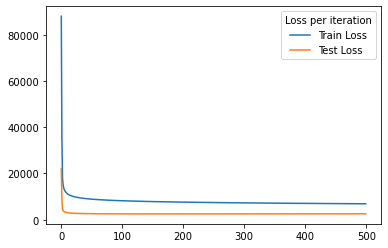

In [181]:
legend1, = plt.plot(trainL)
legend2, = plt.plot(testL)
plt.legend([legend1,legend2],["Train Loss", "Test Loss"], title = "Loss per iteration")
plt.show()

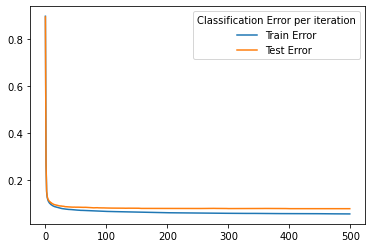

In [182]:
legend1, = plt.plot(trainCE)
legend2, = plt.plot(testCE)
plt.legend([legend1,legend2],["Train Error", "Test Error"], title = "Classification Error per iteration")
plt.show()